We will be comparing the angular velocity in respect to time when different ratios of rotations are sustained.

d=8cm

Firstly we'll rotate with the undistrubed spinner at some arbitrary frequency.

In [113]:
import math
import matplotlib.pyplot as plt
import matplotlib.lines as mpl_lines
import numpy as np

%matplotlib widget

# code modified to change negative values to positive ones
def lmap(f,x):
    return list(map(f,x))

# code modified to change negative values to positive ones
def lfilter(f,x):
    return list(filter(f,x))

def process_raw_decay_data(voltage, startTime = -1, threshold = 0.7, floating_avg = True):
    peaks = []

    # startTime == -1 => auto cutoff
    auto_cutoff = False
    if(startTime == -1):
        auto_cutoff = True
        startTime = 0

    with open(f"./inputs/{voltage}.csv") as inp:
        lines = inp.read().split("\n")

        startInd = 1
        while (float(lines[startInd].split(",")[0]) < startTime): startInd += 1
        
        hitPeak = False
        startPeak = 0
        endPeak = 0
        for i in range(startInd, len(lines)-1):
            row = lines[i].split(",")

            if (abs(float(row[1])) >= threshold and not hitPeak):
                hitPeak = True
                startPeak = float(row[0])


            if (abs(float(row[1])) < threshold and hitPeak):
                hitPeak = False
                endPeak = float(row[0])

                peaks.append((endPeak+startPeak)/2)                

    results = {}
    interval = 1
    step = 0.1
    curTime = startTime
    x = 0
    while x < len(peaks):
        if (peaks[x] > curTime+interval):
            curTime += step
            x = 0
        elif (peaks[x] > curTime and peaks[x] < curTime+interval):
            if (not curTime in results): results[curTime] = 1
            else: results[curTime] += 1
            
        x += 1

    cutoff_val = math.inf
    if(auto_cutoff):
        cutoff_val = 0

    if(floating_avg):   
        with open(f"./outputs/{voltage}_PROCESSED_FLOATING_AVERAGE.csv", 'w') as res:
            res.write("t, peaks/s, omega \n")
            for x in range(4, len(results.keys())):
                flAverage = 0
                for y in range(5):
                    flAverage += results[list(results.keys())[x-y]]
                flAverage = flAverage/5

                if(auto_cutoff):
                    if(flAverage > cutoff_val):
                        cutoff_val = flAverage

                if(flAverage < cutoff_val):
                    res.write(str(round(list(results.keys())[x-y], 1)) + "," + str(flAverage) + "," + str(flAverage*2*math.pi/3) + "\n")

        return f"./outputs/{voltage}_PROCESSED_FLOATING_AVERAGE.csv"
    else:
        with open(f"./outputs/{voltage}_PROCESSED.csv", 'w') as res:
            res.write("t, peaks/s \n")
            for key in results.keys():
                res.write(str(round(key, 1)) + "," + str(results[key]) + "\n")
        
        return f"./outputs/{voltage}_PROCESSED.csv"


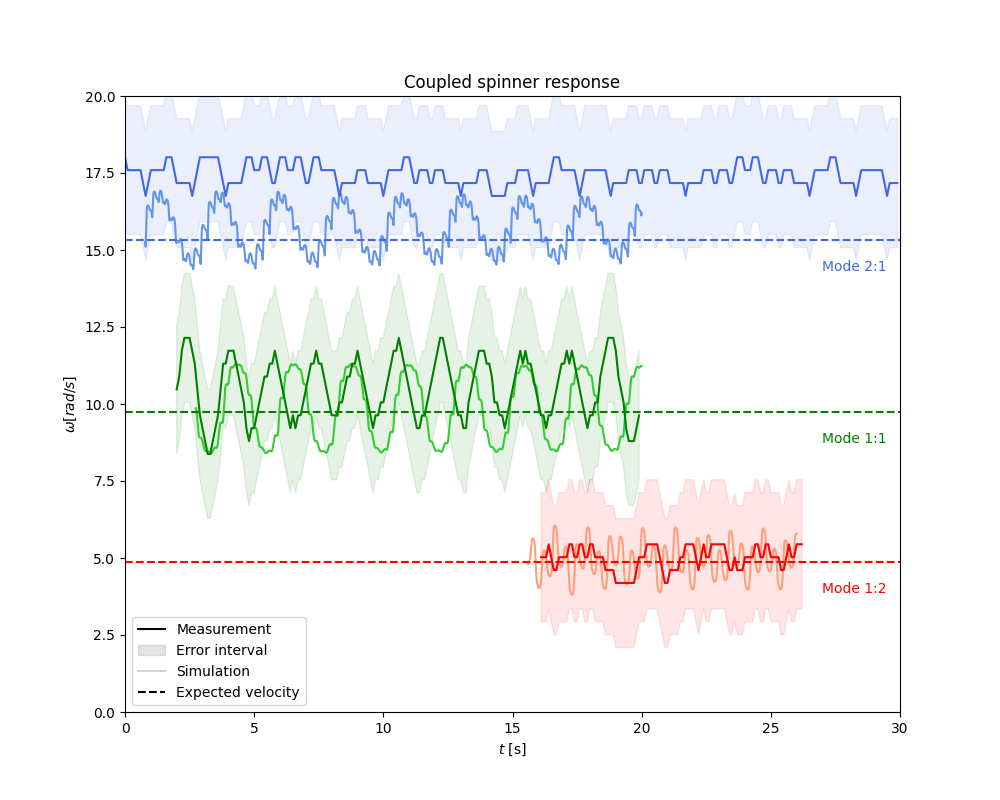

In [114]:
def loadCSV(path, x_id=0, y_id=1):
    with open(path) as inp:
        lines = inp.read().split("\n")[1:-2]
        rows = lmap(lambda l: lmap(float, l.strip().split(",")), lines)

        return {"x": lmap(lambda r: r[x_id], rows), "y": lmap(lambda r: r[y_id], rows)}

vern_samp = 200  # smaples/s

datas = {}
sims = {}

sources = ["1_to_1_3.1V", "1_to_2_3.1V", "2_to_1_2.6V"]

voltages = [3.1, 3.1, 2.6]
expected_ratio = [1, 1 / 2, 2]
names = ["1:1", "1:2", "2:1"]
drill_func = lambda U: 4.1728 * U + -3.1915

xranges = [[2, 20], [15, 26], [0.05, 29.95]]
cols = [
    "limegreen", 
    "lightsalmon",  
    "cornflowerblue",  
]
cols2 = [
    "green", 
    "red",
    "royalblue",
]

plt.figure(figsize=(10,8))

for i in range(len(sources)):
    src = sources[i]
    datas[src] = loadCSV(f"./inputs/{src}.csv", 0, 1)
    
    sims[src] = loadCSV(f"./sim/{src}.csv", 0, 1)

    processed_path = process_raw_decay_data(src, 0)
    datas[src + "_proc"] = loadCSV(processed_path, 0, 2)

    samp = len(datas[src + "_proc"]["x"]) / (
        max(datas[src + "_proc"]["x"]) - min(datas[src + "_proc"]["x"])
    )

    datas[src + "_select"] = {
        "x": datas[src]["x"][int(vern_samp * xranges[i][0]) : int(vern_samp * xranges[i][1])],
        "y": datas[src]["y"][int(vern_samp * xranges[i][0]) : int(vern_samp * xranges[i][1])]
    }

    datas[src + "_proc_select"] = {
        "x": datas[src + "_proc"]["x"][int(samp * xranges[i][0]) : int(samp * xranges[i][1])],
        "y": datas[src + "_proc"]["y"][int(samp * xranges[i][0]) : int(samp * xranges[i][1])]
    }

    plt.plot(
        datas[src + "_proc_select"]["x"],
        datas[src + "_proc_select"]["y"],
        # label= "Mode " + names[i],
        color=cols2[i],
        zorder = 2
    )
    plt.fill(
        datas[src + "_proc_select"]["x"] + datas[src + "_proc_select"]["x"][::-1],
        lmap(lambda x: x+2/3*math.pi, datas[src + "_proc_select"]["y"]) + 
        lmap(lambda x: x-2/3*math.pi, datas[src + "_proc_select"]["y"][::-1]),
        # label= "Error interval (mode " + names[i] + " )",
        color=cols2[i],
        alpha=0.1,
        zorder = 1
    )
    
    plt.axhline(
        drill_func(voltages[i]) * expected_ratio[i], 
        color=cols2[i], 
        linestyle="--", 
        # label="Expected velocity (mode " + names[i] + " )"
    )
    plt.plot(
        sims[src]["x"],
        sims[src]["y"],
        # label= "Simulated (mode " + names[i] + " )",
        color=cols[i],
        linestyle="-",
        zorder=1
    )
    
    plt.text(
        27,
        drill_func(voltages[i]) * expected_ratio[i] - 1,
        "Mode " + names[i],
        color = cols2[i]
    )

plt.axhline(
    -10, 
    color="black", 
    linestyle="-", 
    label="Measurement"
)
plt.fill(
    [-1],
    [-1], 
    color="black", 
    alpha=0.1,
    label="Error interval"
)
plt.axhline(
    -10, 
    color="lightgray", 
    linestyle="-", 
    label="Simulation"
)
plt.axhline(
    -10, 
    color="black", 
    linestyle="--", 
    label="Expected velocity"
)

plt.ylim(0, 20)
plt.xlim(0, 30)
plt.xlabel("$t$ [s]")
plt.ylabel("$\\omega [rad/s]$")
plt.title("Coupled spinner response")
plt.legend()
plt.savefig("simulated_coupling.png", dpi=1000)

Undisturbed spinner:

$$
f_{undistrubed}(t) ... measured \\
\frac{d\varphi}{dt} = \omega
$$

For other spinners we'll shift around the positions of points, to match the undistrubed data and get the new transformed time axis:

$$
f_{distrubed}(t) ... measured \\
\frac{d\varphi}{dt'} = \omega' \\
$$

## Selecting the reference area and processing an average function

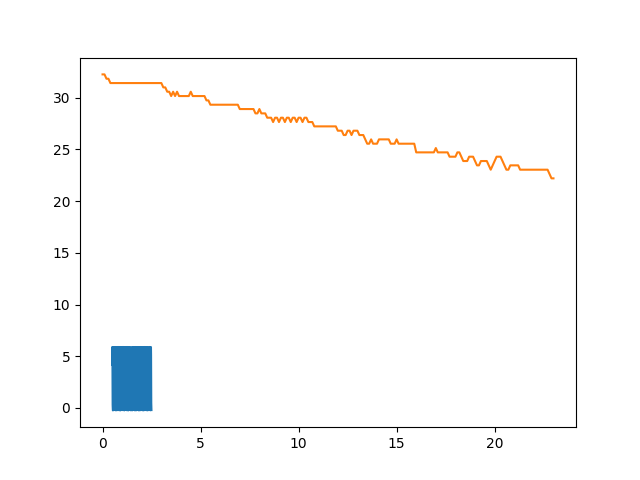

In [115]:
plt.figure()

reference = loadCSV("./inputs/undisturbed.csv")
ref_processed_path = process_raw_decay_data("undisturbed", 0)
reference_proc = loadCSV(ref_processed_path, 0, 2)

# SELECT THE ARE OF THE GRAPH, WHERE THE ANGULAR VELOCITY STAYS PRETTY STABLE
t_0 = 0.49
t_1 = 2.5
plt.plot(
    reference["x"][int(vern_samp * t_0) : int(vern_samp * t_1)], 
    reference["y"][int(vern_samp * t_0) : int(vern_samp * t_1)]
)

plt.plot(
    reference_proc["x"],
    reference_proc["y"],
)

In [116]:
import scipy.signal as sig


def func_avg(functions, targ_len):
    # make an average curve from all the curves
    avg_run = np.zeros(targ_len)
    for i in range(targ_len):
        for f in functions:
            avg_run[i] += f[min(i, len(f) - 1)] / len(functions)
    return avg_run


def segmentate(
    xdata,
    ydata,
    average_out=False,
    peaks_avg_len=0.1,
    resolution_scaler=100,
    smoothing_factor=2,
    display_data=False,
):
    active_x_LD = xdata
    active_y_LD = ydata

    # up the resolution
    def lin_interpolate(v1, v2, count):
        arr = []
        for i in range(count):
            k = i / count
            arr.append(v2 * k + v1 * (1 - k))
        return arr

    active_x = []
    for i in range(len(active_x_LD) - 1):
        active_x += lin_interpolate(
            active_x_LD[i], active_x_LD[i + 1], resolution_scaler
        )
    active_y = []
    for i in range(len(active_y_LD) - 1):
        active_y += lin_interpolate(
            active_y_LD[i], active_y_LD[i + 1], resolution_scaler
        )

    # smooth out the y values
    conv_l = smoothing_factor * resolution_scaler
    active_y = np.convolve(active_y, np.ones(conv_l) / conv_l, "same")

    # find peaks
    peaks, props = sig.find_peaks(active_y, 1, distance=resolution_scaler)

    peaks2 = []
    i = 0
    while i < len(peaks):
        j = 1
        _sum = peaks[i]
        while (
            i + j < len(peaks)
            and j
            < peaks[i + j] - peaks[i]
            < peaks_avg_len * resolution_scaler * vern_samp
        ):
            _sum += peaks[i + j]
            j += 1

        peaks2.append(round(_sum / j))
        i += j

    # display if asked for
    if display_data:
        plt.figure(figsize=(14, 5))
        plt.plot(active_x, active_y)

        for p in peaks:
            plt.axvline(active_x[p], color="b")

        for p in peaks2:
            plt.axvline(active_x[p], color="r")

    # split into intervals
    time_intervals = []
    first_intervals = []
    for i in range(len(peaks2) - 1):
        time_intervals.append(active_x[peaks2[i + 1]] - active_x[peaks2[i]])
        first_intervals.append(active_y[peaks2[i] : peaks2[i + 1]])

        # plt.plot(first_intervals[-1])

    if average_out:
        # make an average curve from all the curves
        avg_intv_len = round(np.average(lmap(len, first_intervals)))

        avg_run = func_avg(first_intervals, avg_intv_len)

        return {
            "x": np.linspace(0, np.average(time_intervals), len(avg_run)),
            "y": avg_run,
            "yerr": func_avg(
                lmap(
                    lambda intv: np.absolute(
                        avg_run[0 : min(len(avg_run), len(intv))]
                        - intv[0 : min(len(avg_run), len(intv))]
                    ),
                    first_intervals,
                ),
                avg_intv_len,
            ),
        }
    else:
        # return all the intervals
        intervals = []
        for i in range(len(peaks2) - 1):
            intervals.append(
                {
                    "x": active_x[peaks2[i] : peaks2[i + 1]],
                    "y": active_y[peaks2[i] : peaks2[i + 1]],
                }
            )
        return intervals


def normalize_func(f, with_err = False):
    # SPLIT INTO RIGHT AND LEFT PARTS
    min_y = min(f["y"])
    min_id = f["y"].tolist().index(min_y)

    lx = f["x"][:min_id]
    ly = f["y"][:min_id]
    rx = f["x"][min_id:]
    ry = f["y"][min_id:]

    return {
        "r": {
            "x": np.linspace(0.5, 1, len(rx)),
            "y": np.multiply(lmap(lambda v: v - min(ry), ry), 1 / (-min(ry) + max(ry))),
            "max_y": max(ry),
            "min_y": min(ry),
            "max_x": max(rx),
            "min_x": min(rx),
            "yerr": f["yerr"][len(ly):] / (max(ry) - min(ry)) if with_err else None,
        },
        "l": {
            "x": np.linspace(0, 0.5, len(lx)),
            "y": np.multiply(lmap(lambda v: v - min(ly), ly), 1 / (-min(ly) + max(ly))),
            "max_y": max(ly),
            "min_y": min(ly),
            "max_x": max(lx),
            "min_x": min(lx),
            "yerr": f["yerr"][0 : len(ly)] / (max(ly) - min(ly)) if with_err else None,
        },
    }


def unnormalize(f):
    xl = lmap(
        lambda t: t * (f["l"]["max_x"] - f["l"]["min_x"]) + f["l"]["min_x"], f["l"]["x"]
    )
    yl = lmap(
        lambda v: v + f["l"]["min_y"],
        np.multiply(f["l"]["y"], -f["l"]["min_y"] + f["l"]["max_y"]),
    )

    xr = lmap(
        lambda t: t * (f["r"]["max_x"] - f["r"]["min_x"]) + f["r"]["min_x"], f["r"]["x"]
    )
    yr = lmap(
        lambda v: v + f["r"]["min_y"],
        np.multiply(f["r"]["y"], -f["r"]["min_y"] + f["r"]["max_y"]),
    )

    return {
        "x": xl + xr,
        "y": yl + yr,
    }

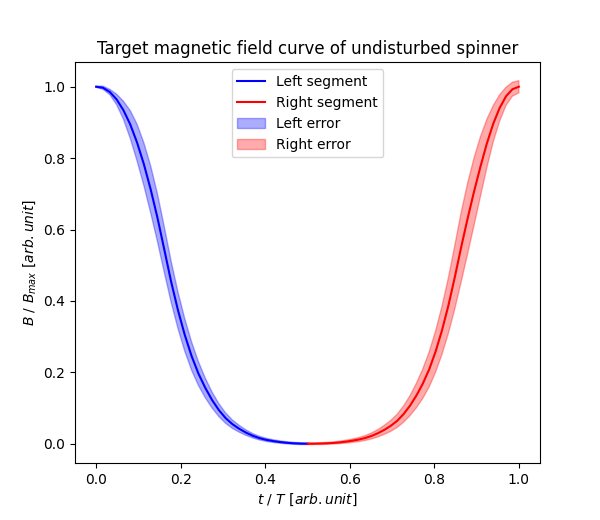

In [117]:
target = segmentate(
    reference["x"][int(vern_samp * t_0) : int(vern_samp * t_1)],
    reference["y"][int(vern_samp * t_0) : int(vern_samp * t_1)],
    True,
    peaks_avg_len=0.001,
    resolution_scaler=5,
    smoothing_factor=1,
    display_data=False,
)

target_norm = normalize_func(target, True)

plt.subplots(figsize=[6,5.2])
plt.title("Target magnetic field curve of undisturbed spinner")
plt.xlabel("$t$ $/$ $T$ $[arb. unit]$")
plt.ylabel("$B$ $/$ $B_{max}$ $[arb. unit]$")
plt.plot(target_norm["l"]["x"], target_norm["l"]["y"], c="b", label = "Left segment")
plt.plot(target_norm["r"]["x"], target_norm["r"]["y"], c="r", label = "Right segment")

plt.fill(
    list(target_norm["l"]["x"]) + list(target_norm["l"]["x"])[::-1],
    list(target_norm["l"]["y"] + target_norm["l"]["yerr"])+
    list(target_norm["l"]["y"] - target_norm["l"]["yerr"])[::-1],
    c="b",
    alpha = 0.33,
    label = "Left error"
)

plt.fill(
    list(target_norm["r"]["x"]) + list(target_norm["r"]["x"])[::-1],
    list(target_norm["r"]["y"] + target_norm["r"]["yerr"])+
    list(target_norm["r"]["y"] - target_norm["r"]["yerr"])[::-1],
    c="r",
    alpha = 0.33,
    label = "Right error"
)

plt.legend(loc="upper center")
plt.savefig("target_curve.png", dpi=1000)

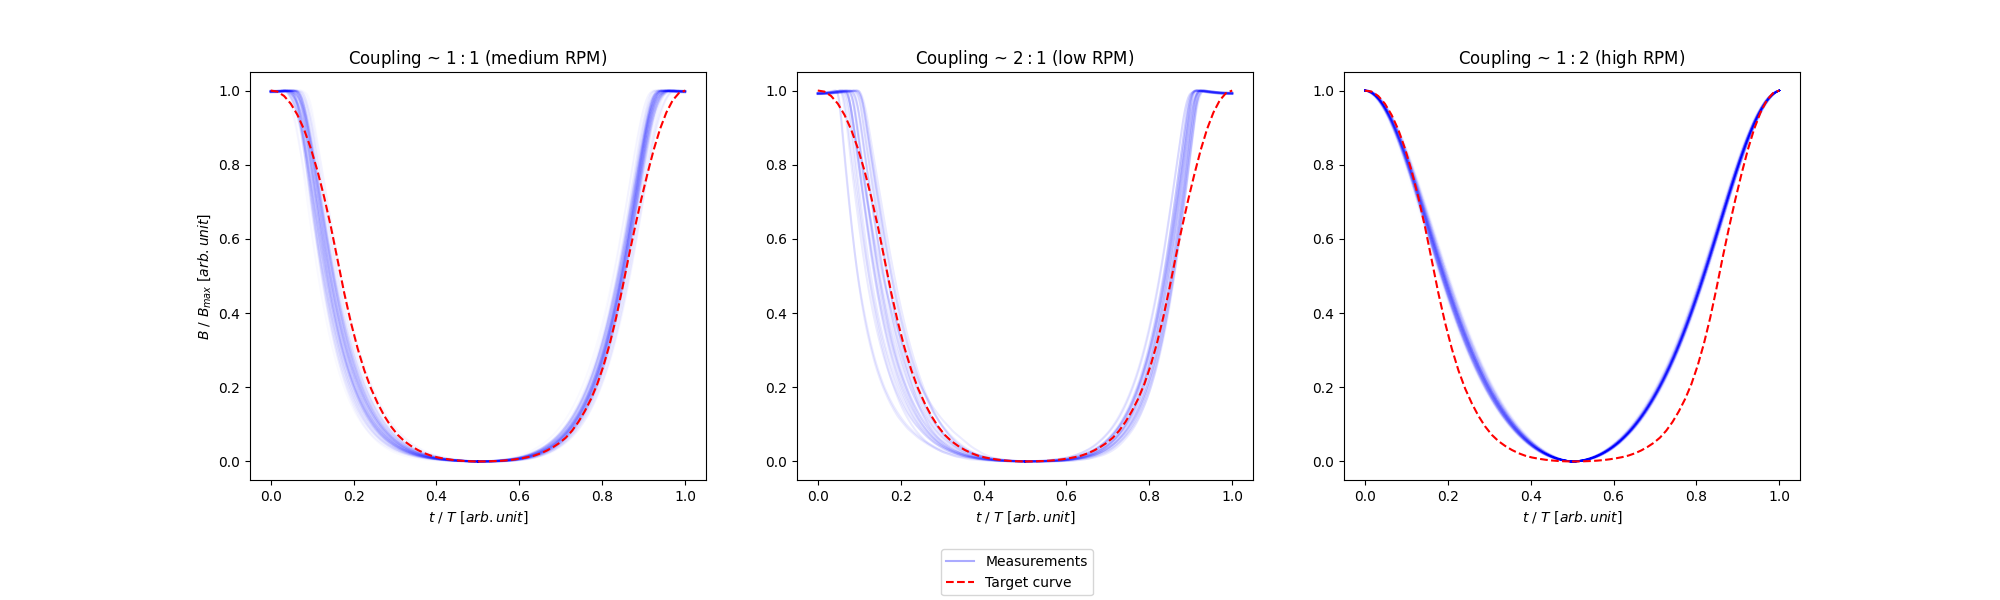

In [118]:
fig, ax = plt.subplots(1, 3, figsize = [20, 6])
plt.subplots_adjust(bottom = 0.2)

coupling_names = [
    "Coupling ~ $1:1$ (medium RPM)",
    "Coupling ~ $2:1$ (low RPM)",
    "Coupling ~ $1:2$ (high RPM)"
]

parsed_srcs = {}
for j in range(len(sources)):
    src = sources[j]

    intervals = segmentate(
        datas[src + "_select"]["x"],
        datas[src + "_select"]["y"],
        False,
        0.1,
        5,
        1,
        False,
    )

    intervals_norm = lmap(normalize_func, intervals)

    for i in intervals_norm:
        ax[j].plot(i["l"]["x"], i["l"]["y"], c="b", alpha=2/len(intervals_norm))
        ax[j].plot(i["r"]["x"], i["r"]["y"], c="b", alpha=2/len(intervals_norm))

    ax[j].plot(target_norm["l"]["x"], target_norm["l"]["y"], "r--")
    ax[j].plot(target_norm["r"]["x"], target_norm["r"]["y"], "r--")
    
    if(j == 0):
        ax[j].legend(loc="lower left", labels = ["Measurements", "Target curve"], handles = [mpl_lines.Line2D([0], [1], c="b", alpha=0.33), mpl_lines.Line2D([0], [1], c="r", linestyle="--")], bbox_to_anchor = [1.5, -0.3])
        ax[j].set_ylabel("$B$ $/$ $B_{max}$ $[arb. unit]$")
    ax[j].set_xlabel("$t$ $/$ $T$ $[arb. unit]$")
    ax[j].set_title(coupling_names[j])
    
    parsed_srcs[src] = {"intervals": intervals, "intervals_norm": intervals_norm}
plt.savefig("B_sub_period.png", dpi=1000)


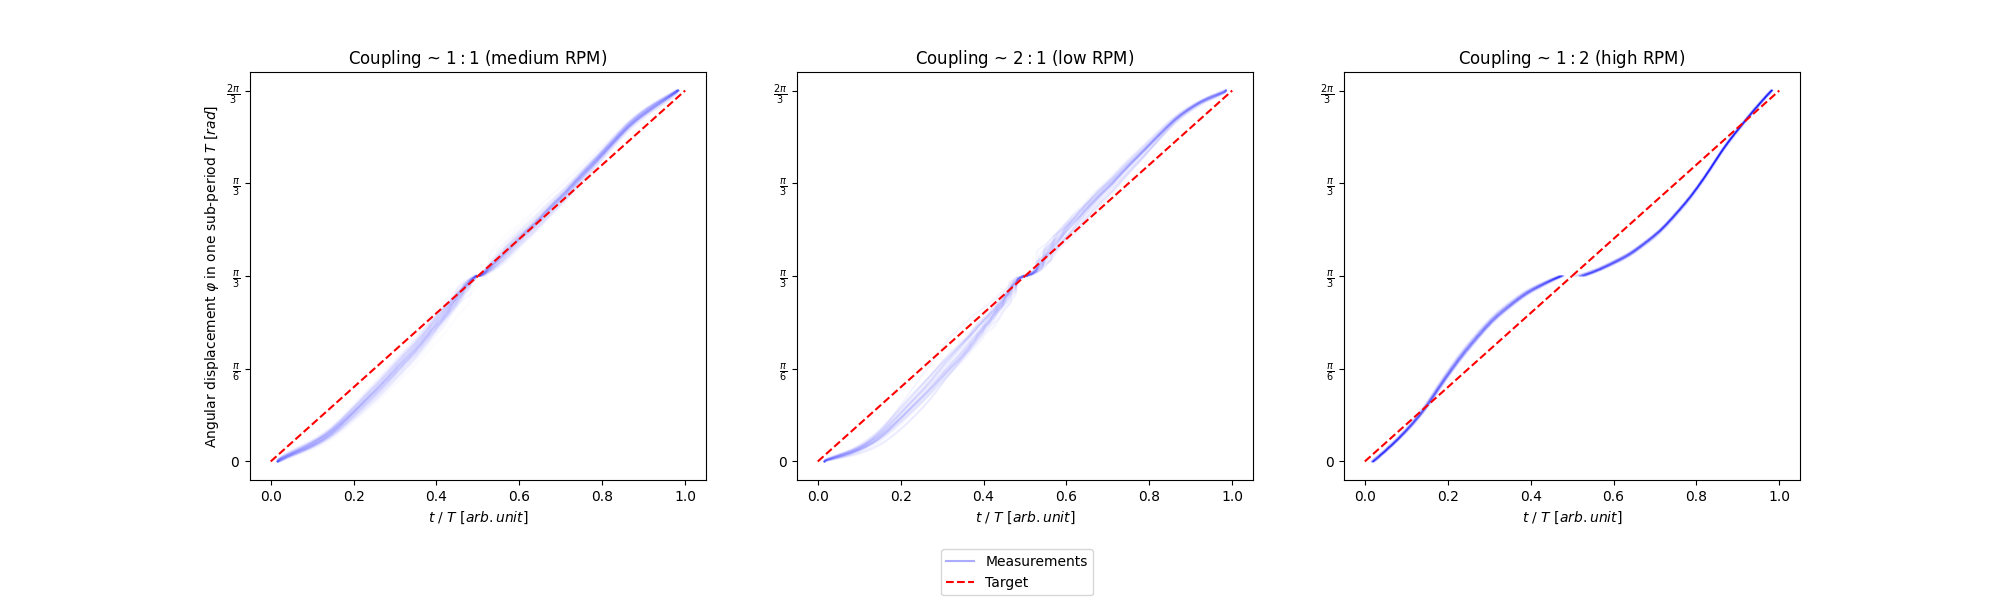

In [119]:
def transform_func(target, func, dir=-1):
    t_0 = target["x"][::dir][0]

    indexes_to_remove = []
    out_t = []

    for i in range(len(func["x"]))[::dir]:
        t = func["x"][i]
        v = func["y"][i]

        search_interval_start = max(
            target["x"]
            .tolist()
            .index(lfilter(lambda t: dir * t > dir * t_0, target["x"])[0])
            - 1,
            0,
        )

        # find the interval in which this value lies
        found = False
        for j in range(search_interval_start, len(target["x"]))[::dir][0:-2]:
            t_targ_0 = target["x"][j]
            v_targ_0 = target["y"][j]

            t_targ_1 = target["x"][j + dir]
            v_targ_1 = target["y"][j + dir]

            if v >= v_targ_0 and v < v_targ_1:
                n_t = (t_targ_1 - t_targ_0) * (v - v_targ_0) / (
                    v_targ_1 - v_targ_0
                ) + t_targ_0

                if n_t * dir > t_0 * dir:
                    # lies in the current interval
                    if len(out_t) > 1:
                        if n_t * dir >= out_t[-1] * dir:
                            out_t.append(n_t)
                            found = True

                            t_0 = t_targ_0

                            break
                    else:
                        out_t.append(n_t)
                        found = True

                        t_0 = t_targ_0

                        break

        if not found:
            # remove values that could not be determined
            indexes_to_remove.append(i)

    return {
        "x": out_t[::dir],
        "y": lmap(
            lambda i: func["y"][i],
            lfilter(lambda i: not i in indexes_to_remove, range(len(func["y"]))),
        ),
        "max_y": func["max_y"],
        "min_y": func["min_y"],
        "max_x": func["max_x"],
        "min_x": func["min_x"],
    }

fig, ax = plt.subplots(1, 3, figsize = [20, 6])
plt.subplots_adjust(bottom = 0.2)

fin = {}
for i in range(len(sources)):
    src = sources[i]

    intervals_norm = parsed_srcs[src]["intervals_norm"]

    for intv in intervals_norm:
        trans_l = transform_func(target_norm["l"], intv["l"], -1)
        trans_r = transform_func(target_norm["r"], intv["r"], 1)

        # plt.xlim(0.3, 0.5)
        # plt.xlim(0.3, 0.5)
        # plt.scatter(trans_l["x"], trans_l["x"])

        # unnorm = unnormalize(
        #     {
        #         "l": trans_l,
        #         "r": trans_r,
        #     }
        # )

        fin[src] = {
            "l":{
                "x": trans_l["x"],
                "y":np.linspace(0, math.pi / 3, len(trans_l["x"]))
            },
            "r":{
                "x": trans_r["x"],
                "y": np.linspace(math.pi / 3, 2 * math.pi / 3, len(trans_r["x"]))
            }
        }

        ax[i].plot(
            trans_l["x"],
            np.linspace(0, math.pi / 3, len(trans_l["x"])),
            "b",
            alpha=1/len(intervals_norm),
        )

        ax[i].plot(
            trans_r["x"],
            np.linspace(math.pi / 3, 2 * math.pi / 3, len(trans_r["x"])),
            "b",
            alpha=1/len(intervals_norm),
        )
    
    ax[i].plot(
        target_norm["l"]["x"],
        np.linspace(0, math.pi / 3, len(target_norm["l"]["x"])),
        "r--",
    )

    ax[i].plot(
        target_norm["r"]["x"],
        np.linspace(math.pi / 3, 2 * math.pi / 3, len(target_norm["r"]["x"])),
        "r--",
    )
    
    if(i == 0):
        ax[i].legend(loc="lower left", labels = ["Measurements", "Target"], handles = [mpl_lines.Line2D([0], [1], c="b", alpha=0.33), mpl_lines.Line2D([0], [1], c="r", linestyle="--")], bbox_to_anchor = [1.5, -0.3])
        ax[i].set_ylabel("Angular displacement $\\varphi$ in one sub-period $T$ $[rad]$")
    ax[i].set_xlabel("$t$ $/$ $T$ $[arb. unit]$")
    ax[i].set_yticks([0, math.pi / 6, math.pi / 3, 3 * math.pi/6, 2* math.pi/3])
    ax[i].set_yticklabels(["$0$", "$\\frac{\\pi}{6}$", "$\\frac{\\pi}{3}$", "$\\frac{\\pi}{3}$", "$\\frac{2\\pi}{3}$"])
    ax[i].set_title(coupling_names[i])
plt.savefig("ang_sub_period.png", dpi=1000)

C:\Users\ondra\AppData\Local\Temp\ipykernel_44364\1542226712.py:55: RuntimeWarning: invalid value encountered in true_divide
  uncertainty = np.diff(list(target_norm["l"]["y"]) + list(target_norm["r"]["y"])) / np.diff(list(target_norm["l"]["x"]) + list(target_norm["r"]["x"]))
C:\Users\ondra\AppData\Local\Temp\ipykernel_44364\1542226712.py:63: RuntimeWarning: divide by zero encountered in true_divide
  dly = np.diff(fin[src]["l"]["y"]) / np.diff(fin[src]["l"]["x"])


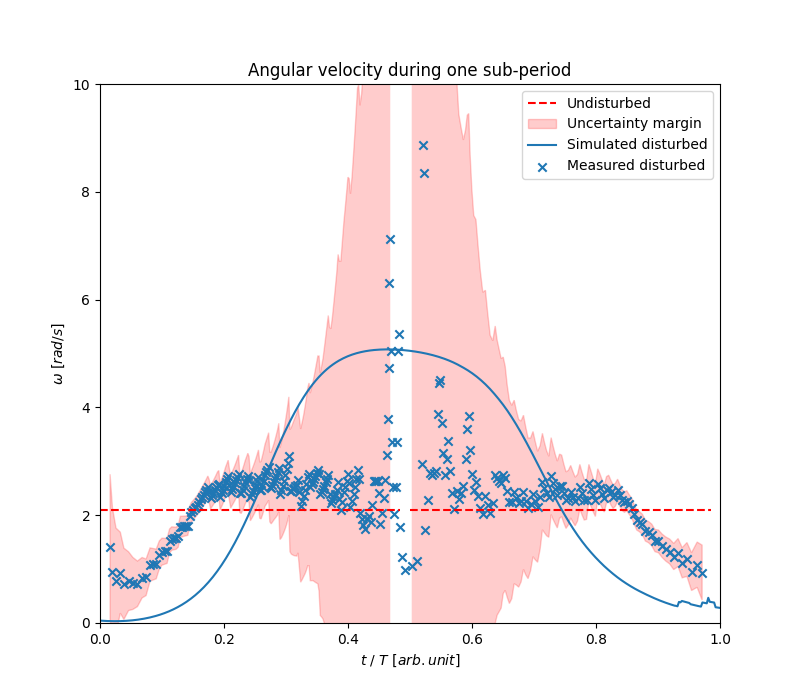

In [120]:
import scipy.interpolate as inter
for j in [1]:
    src = sources[j]
    plt.figure(figsize=[8,7])

    # simulation
    sim_data = loadCSV(f"sim/{src}.csv", 0, 2)
    sim_data_phi = loadCSV(f"sim/{src}.csv", 0, 2)
    
    # splitting points
    splitting_points = []
    for i in range(len(sim_data_phi["y"])):
        ang = sim_data_phi["y"][i]
        if (ang - sim_data["y"][0]) > 2/3 * math.pi:
            sim_data_phi["y"] = lmap(lambda x: x - 2/3 * math.pi,  sim_data_phi["y"])
            splitting_points.append(i)
    
            # plt.vlines(sim_data_phi["x"][i], 0, 10, color="r", linestyle="--")
    intervals = []
    for i in range(len(splitting_points)-1):
        try:
            intervals.append({
                "x": np.linspace(0,1,-splitting_points[i] + splitting_points[i+1]),
                "y": np.array(sim_data["y"][splitting_points[i] : splitting_points[i+1]]) - (i+1)*2/3*math.pi
            })
            
            # plt.plot(
            #     sim_data["x"][splitting_points[i] : splitting_points[i+1]], 
            #     np.array(sim_data["y"][splitting_points[i] : splitting_points[i+1]])
            # )
            pass
        except Exception as e:
            print(e)
    
    avg_l = round(np.average(lmap(lambda x: len(x["x"]), intervals)))
    avg_x = func_avg(lmap(lambda intv: intv["x"], intervals), avg_l)
    avg_y = func_avg(lmap(lambda intv: intv["y"], intervals), avg_l)
    avg_y = lmap(lambda i: drill_func(voltages[j]) * (avg_y[i] - avg_x[i] * (max(avg_y))), range(len(avg_x)))

    # derivative of control
    plt.plot(
        target_norm["l"]["x"][0:-1],
        np.diff(np.linspace(0, math.pi / 3, len(target_norm["l"]["x"])))
        / np.diff(target_norm["l"]["x"]),
        "r--",
        label = "Undisturbed"
    )
    plt.plot(
        target_norm["r"]["x"][0:-1],
        np.diff(np.linspace(math.pi / 3, 2 * math.pi / 3, len(target_norm["r"]["x"])))
        / np.diff(target_norm["r"]["x"]),
        "r--",
    )
    
    uncertainty = np.diff(list(target_norm["l"]["y"]) + list(target_norm["r"]["y"])) / np.diff(list(target_norm["l"]["x"]) + list(target_norm["r"]["x"]))
    uncertainty_func = inter.interp1d(np.linspace(0,1, len(uncertainty)), abs(1/uncertainty))
    
    plt.xlim(0,1)
    plt.ylim(0,10)
    
    # derivative of measured
    lx = fin[src]["l"]["x"][0:-1]
    dly = np.diff(fin[src]["l"]["y"]) / np.diff(fin[src]["l"]["x"])
    rx = fin[src]["r"]["x"][0:-1]
    dry = np.diff(fin[src]["r"]["y"]) / np.diff(fin[src]["r"]["x"])
    plt.fill(
        lx[::-1] + lx + rx + rx[::-1],
        list(dly + lmap(uncertainty_func, lx))[::-1] + list(dly - lmap(uncertainty_func, lx))
        +list(dry + lmap(uncertainty_func, rx)) + list(dry - lmap(uncertainty_func, rx))[::-1],
        color="red",
        alpha=0.2,
        label = "Uncertainty margin"
    )
    
    plt.plot(
        np.linspace(0,1,len(avg_x)-1), 
        np.diff(avg_y)/np.diff(avg_x) + 2/3*math.pi,
        label = "Simulated disturbed"
    )
    
    plt.scatter(
        lx + rx,
        list(dly) + list(dry),
        label = "Measured disturbed",
        marker="x"
    )

plt.legend()
plt.title("Angular velocity during one sub-period")
plt.xlabel("$t$ $/$ $T$ $[arb. unit]$")
plt.ylabel("$\\omega$ $[rad/s]$")
plt.savefig("ang_vel_sub_period.png", dpi=1000)
    

### **NOTE! one "sub-period" is the period it takes for the spinner to spin from one magnet to the next**